In [1]:
import sklearn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

### Ensemble Learning

Diverse set of different classifiers.

In [23]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=4)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
r_forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42, probability=True) # probability = True so SVC has predict_prob() function

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", r_forest_clf), ("svc", svm_clf)],
    voting="soft" # all classes need to be able to have a predict_proba() function for soft voting
) # soft voting in general better than hard voting since soft voting weighs confident votes higer

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf',
                              RandomForestClassifier(n_estimators=10,
                                                     random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
# check voting classifier's accuracy 
from sklearn.metrics import accuracy_score

for clf in (log_clf, r_forest_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    acc_score = accuracy_score(y_train, y_pred)
    print(f"{clf.__class__.__name__} accuracy = {acc_score:.4f}")

LogisticRegression accuracy = 0.8747
RandomForestClassifier accuracy = 0.9973
SVC accuracy = 0.9120
VotingClassifier accuracy = 0.9360


Voting classifier should perform better than all of the individual classifiers but Random Forest Classifier seems to be too good...

### Bagging and Pasting

Set of the same classifiers but all trained on different subsets of training data.
Decreases bias and variance than if only using a single classifier.

Bagging = with replacement. Pasting = without replacement.

Bagging ends up with slightly higher bias than pasting, but this means that predictors end up being less correlated so the ensemble variance is reduced.

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1) # n_jobs = -1 means use all available CPU cores
                                                # bootstrap = True means to use bagging
                                                # bootstrap = False means to use pasting

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [9]:
print("Accuracy for bag_clf = ", accuracy_score(y_test, y_pred))

Accuracy for bag_clf =  0.904


In [10]:
# single Decision Tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
print("Accuracy for single Decision Tree = ", accuracy_score(y_test, y_pred))

Accuracy for single Decision Tree =  0.864


In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

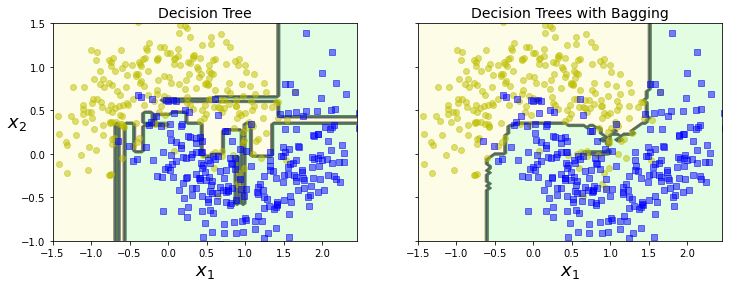

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

### Out of Bag Evaluation

On average, only 66% of samples will be seen by individual predictor/classifiers. Can use the other 33% as evaluation data for each individual predictor. The evaluation scores of each individual one will be the evaluation score of the overall ensemble.

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
print(f"Bagging Classifier OOB Score = {bag_clf.oob_score_}")

Bagging Classifier OOB Score = 0.888


In [19]:
# according to OOB, about 90% accuracy on test set
# verify this
y_pred = bag_clf.predict(X_test)
print(f"Bagging Classifier Accuracy = {accuracy_score(y_test, y_pred):.4f}")

Bagging Classifier Accuracy = 0.9120


### Random Forests

An ensemble of Decision Trees. The code below is almost equivalent.

In [21]:
from sklearn.ensemble import RandomForestClassifier

r_forest_clf = RandomForestClassifier(n_estimators=500, 
                                      max_leaf_nodes=16, 
                                      random_state=42,
                                      n_jobs=-1)
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42, splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

r_forest_clf.fit(X_train, y_train)
bag_clf.fit(X_train, y_train)

y_pred_forest = r_forest_clf.predict(X_test)
y_pred_bag = bag_clf.predict(X_test)

forest_acc = accuracy_score(y_test, y_pred_forest)
bag_acc = accuracy_score(y_test, y_pred_bag)

print(f"Random Forest acc = {forest_acc} || Bagging Classifier acc = {bag_acc}")

Random Forest acc = 0.92 || Bagging Classifier acc = 0.896


### Feature Importance

Great quality of Random Forests is that they make it easy to measure the relative importance of each feature based on how much of the tree nodes use this feature to reduce impurity (weighted based on the samples at each node of course).

In [25]:
from sklearn.datasets import load_iris

iris = load_iris()
r_forest_iris = RandomForestClassifier(random_state=42, n_estimators=500, n_jobs=-1)
r_forest_iris.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], r_forest_iris.feature_importances_):
    print(f"Feature = {name} : Importance Score = {score:.4f}")

Feature = sepal length (cm) : Importance Score = 0.1125
Feature = sepal width (cm) : Importance Score = 0.0231
Feature = petal length (cm) : Importance Score = 0.4410
Feature = petal width (cm) : Importance Score = 0.4234


### Boosting

Boosting is when any Ensemble method combines several weak learners into a strong learner.

### Adaboost

Adaboost trains one predictor and then trains the next sequential predictor with more weight on the samples that the previous predictor did not classify correctly.

In [27]:
from sklearn.ensemble import AdaBoostClassifier

# sklearn implementation
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

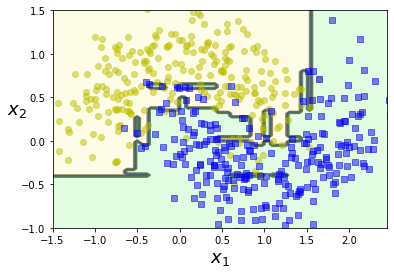

In [28]:
plot_decision_boundary(ada_clf, X, y)

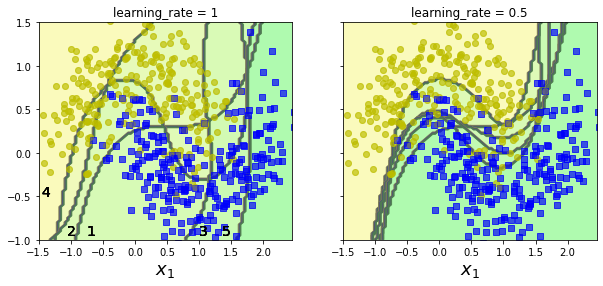

In [30]:
# write Adaboost algorithm out
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5): # Adaboost with 5 predictors/classifiers
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        pred = svm_clf.predict(X_train)
        # eqn 7-1 from book
        r = sample_weights[y_train != pred].sum() / sample_weights.sum()
        # eqn 7-2
        alpha = learning_rate * np.log((1-r)/r)
        # eqn 7-3
        sample_weights[y_train != pred] *= np.exp(alpha)
        # normalization
        sample_weights /= sample_weights.sum()

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)

        plt.title("learning_rate = {}".format(learning_rate), fontsize=12)
        
        if subplot == 0:
            plt.text(-0.75, -0.95, "1", fontsize=14)
            plt.text(-1.05, -0.95, "2", fontsize=14)
            plt.text(1.0, -0.95, "3", fontsize=14)
            plt.text(-1.45, -0.5, "4", fontsize=14)
            plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

### Gradient Boosting

Similar to Adaboost but instead tries to fit new predictor to the residual errors made by the previous predictor.

In [86]:
# generate some noisy quadratic data 
np.random.seed(42)
X = np.random.rand(100,1) - 0.5 # subtract the mean to "standardize the data"
y = 3*X[:,0]**2 + 0.05 * np.random.randn(100)

In [87]:
from sklearn.tree import DecisionTreeRegressor

tree_reg_1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg_1.fit(X, y)
y_0 = y
y_1 = tree_reg_1.predict(X)

In [88]:
# now train second predictor on the residual errors the first predictor made
for i in range(2, 4): # train two more predictors
    exec(f"y_{i} = y_{i-2} - y_{i-1}")
    exec(f"tree_reg_{i} = DecisionTreeRegressor(max_depth=2, random_state=42)")
    eval(f"tree_reg_{i}.fit(X, y_{i})")
    exec(f"y_{i} = tree_reg_{i}.predict(X)")

In [92]:
y_pred_grad_boost = tree_reg_1.predict(X) + tree_reg_2.predict(X) + tree_reg_3.predict(X)
print(f"MSE = {mean_squared_error(y, y_pred_grad_boost)}")

MSE = 0.1187158616091554


In [91]:
# can use sklearn library instead
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# learning_rate hyperparam scales the contribution of each tree
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
# if learning_rate is low, add more estimators
# technique called shrinkage -> predictions will generalize better
gbrt.fit(X, y)
y_pred = gbrt.predict(X)
print(f"MSE = {mean_squared_error(y, y_pred)}")

MSE = 0.005038058938993283


To find the optimal number of trees, can use early stopping.

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(random_state=42, max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors)
print(f"Best num estimators = {best_n_estimators}")

gbrt_best = GradientBoostingRegressor(random_state=42,
                                      max_depth=2, 
                                      n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

Best num estimators = 87


GradientBoostingRegressor(max_depth=2, n_estimators=87, random_state=42)

In [94]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

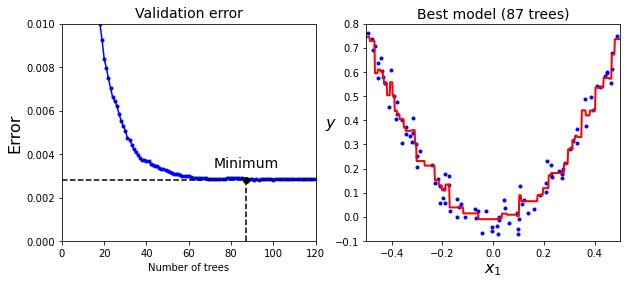

In [95]:
min_error = np.min(errors)
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

In [98]:
# can also stop training when validation error does not improve for 
# a certain number of iterations

# do this by setting hyperparam warm_start=True
# this makes sklearn to keep existing trees when fit() is called 
# and allows for incremental training
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up >= 5:
            break

print(f"Best n_estimators with early stop is {n_estimators} estimators.")

Best n_estimators with early stop is 78 estimators.


`xgboost` (Extreme Gradient Boosting) is an optimized implementation of Gradient Boosting. 

In [103]:
import xgboost

xgb_reg = xgboost.XGBRegressor(early_stopping_rounds=2)
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)])
y_pred = xgb_reg.predict(X_val)


[0]	validation_0-rmse:0.26584
[1]	validation_0-rmse:0.20004
[2]	validation_0-rmse:0.15351
[3]	validation_0-rmse:0.12042
[4]	validation_0-rmse:0.09830
[5]	validation_0-rmse:0.08311
[6]	validation_0-rmse:0.07191
[7]	validation_0-rmse:0.06441
[8]	validation_0-rmse:0.06027
[9]	validation_0-rmse:0.05782
[10]	validation_0-rmse:0.05609
[11]	validation_0-rmse:0.05530
[12]	validation_0-rmse:0.05390
[13]	validation_0-rmse:0.05374
[14]	validation_0-rmse:0.05327
[15]	validation_0-rmse:0.05300
[16]	validation_0-rmse:0.05275
[17]	validation_0-rmse:0.05263
[18]	validation_0-rmse:0.05264
[19]	validation_0-rmse:0.05259
[20]	validation_0-rmse:0.05262
[21]	validation_0-rmse:0.05263


### Stacking

Instead of using trivial functions (i.e. hard voting) to aggregate predictions, train a model to perform this aggregation.

In [113]:
# no sklearn implementation so write myself
stack_clfs = []
num_clf = 3

# add the classifiers
for i in range(num_clf):
    stack_clfs.append(DecisionTreeRegressor(max_depth=2))
    
# train classifiers to make blended training set
X_blended = np.empty((len(X_val), num_clf))

for i, clf in enumerate(stack_clfs):
    clf.fit(X_train, y_train)
    X_blended[:, i] = clf.predict(X_val)

blender = DecisionTreeRegressor(max_depth=2)
blender.fit(X_blended, y_val)

DecisionTreeRegressor(max_depth=2)